# Regression task: the time interval between two consecutive visits for the same patient ~ ICD diagnosis code

## Prepare the dataset

In [17]:
""" 
Patient ID -> admission ID
"""

' \nPatient ID -> admission ID\n'

In [18]:
import sys
sys.path.append("/home/wanxinli/deep_patient/")

from datetime import datetime
from mimic_common import *
import os
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import gaussian_process



In [19]:
output_dir = os.path.join(os.path.expanduser("~"), f"deep_patient/outputs/mimic")
print(f"Will save outputs to {output_dir}")
data_dir = os.path.join(os.path.expanduser("~"), f"deep_patient/mimic_exp/mimiciii")
print(f"Will read data from {data_dir}")

Will save outputs to /home/wanxinli/deep_patient/outputs/mimic
Will read data from /home/wanxinli/deep_patient/mimic_exp/mimiciii


In [20]:
admission_file = os.path.join(data_dir, "ADMISSIONS.csv")
diagnosis_file = os.path.join(data_dir, "DIAGNOSES_ICD.csv")
patient_file = os.path.join(data_dir, "PATIENTS.csv")

In [21]:
pid_adms, pid_gender, adm_date, admid_codes, pid_visits = build_maps(admission_file, diagnosis_file, patient_file)


In [22]:
# print(pid_visits)

In [23]:
# construct codes (ICD codes for the first visits), and durations (time interval until the next visit)

codes = []
durations = []
genders = []
for pid, visits in pid_visits.items():
    for i, cur_visit in enumerate(visits):
        if i == len(visits)-1: # stop on the last element
            break 
        next_visit = visits[i+1]
        # print(next_visit)
        cur_codes = cur_visit[1]
        # print(codes)
        duration = (next_visit[0]-cur_visit[0]).total_seconds()
        codes.append(cur_codes)
        durations.append(duration)
        genders.append(pid_gender[pid])


cons_visits_df = pd.DataFrame(columns=['gender', 'duration', 'ICD codes'])
cons_visits_df['gender'] = genders
cons_visits_df['duration'] = durations
cons_visits_df['ICD codes'] = codes
cons_visits_df.to_csv(os.path.join(output_dir, "CONS_VISITS.csv"), index=False, header=True)

cons_visits_df

,gender,duration,ICD codes
0,M,130162740.0,"[41401, 4111, 4241, V4582, 2724, 4019, 60000, ..."
1,M,145197420.0,"[41071, 4280, 4254, 42731, 9971, 4260, 41401, ..."
2,M,1082040.0,"[41401, 4111, 496, 4019, 3051, 53081, 60000, V..."
3,M,94491660.0,"[99831, 99811, 41511, 4538, 99672, 496, 41401,..."
4,M,20640960.0,"[5715, 5722, 2867, 45620, 3453, 48241, 51881, ..."
...,...,...,...
12451,M,9735840.0,"[42731, 56211, V1051]"
12452,M,8103720.0,"[99859, 0389, 99592, 78552, 5849, 5990, 42830,..."
12453,F,2644440.0,"[4373, 4019, 2449, 59651, 49390, V1052]"
12454,F,1994400.0,"[5363, 5641]"


In [24]:
""" 
Outputs consecutive visit stats
"""
female_count = cons_visits_df.loc[(cons_visits_df['gender'] == 'F')].shape[0]
male_count = cons_visits_df.loc[(cons_visits_df['gender'] == 'M')].shape[0]
print("female count is:", female_count)
print("male count is:", male_count)

female count is: 5627
male count is: 6829


In [25]:
"""
Train deep patient model and generate representations for targets and sources
"""

def custom_train_reps(target_features, source_features, n_components, pca_explain=False):
    """ 
    Customized training algorithm for generating target representations and source representations

    :param bool pca_explain: print the explained variance of each components
    
    :returns: target representations, source representations
    """
    source_pca = PCA(n_components=n_components)
    target_pca = PCA(n_components=n_components)
    target_reps = target_pca.fit_transform(target_features)
    source_reps = source_pca.fit_transform(source_features)

    if pca_explain:
        source_exp_var = source_pca.explained_variance_ratio_
        source_cum_sum_var = np.cumsum(source_exp_var)
        target_exp_var = target_pca.explained_variance_ratio_
        target_cum_sum_var = np.cumsum(target_exp_var)
        print("Cummulative variance explained by the source PCA is:", source_cum_sum_var)
        print("Cummulative variance explained by the target PCA is:", target_cum_sum_var)

    return target_reps, source_reps

In [26]:
n_components = 20
model_func = linear_model.PoissonRegressor
entire_proc_cts(n_components, cons_visits_df, custom_train_reps, model_func, male_count = 120, female_count = 100, pca_explain=False)

/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


(29791838.681487437,
 44404842.21037529,
 53740043.07811273,
 84916650.18747346,
 48242156.09049678,
 71502398.81927487)

In [27]:
model_func = linear_model.LinearRegression
entire_proc_cts(n_components, cons_visits_df, custom_train_reps, model_func, male_count = 120, female_count = 100, pca_explain=False)

(33228197.62828556,
 47866465.50980365,
 46739915.57833557,
 63854683.81844482,
 43072916.08147015,
 60437979.88141065)

In [28]:
""" 
Run multiple iterations using Poisson regression
"""

score_path = os.path.join(output_dir, "exp5_poisson_score_"+str(n_components)+".csv")
male_count = 120
female_count = 100

multi_proc_cts(score_path, n_components, cons_visits_df, custom_train_reps, \
    male_count, female_count, model_func = linear_model.PoissonRegressor, iteration=100)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 5
iteration: 6
iteration: 7


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 8
iteration: 9
iteration: 10
iteration: 11


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 12
iteration: 13
iteration: 14
iteration: 15


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 16
iteration: 17
iteration: 18
iteration: 19


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 20


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 21
iteration: 22


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 23
iteration: 24


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 25


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 26


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 39
iteration: 40
iteration: 41
iteration: 42


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 59
iteration: 60


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 61
iteration: 62
iteration: 63


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
iteration: 72
iteration: 73


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 74
iteration: 75
iteration: 76


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 77
iteration: 78
iteration: 79
iteration: 80


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 81
iteration: 82
iteration: 83
iteration: 84
iteration: 85
iteration: 86
iteration: 87
iteration: 88
iteration: 89
iteration: 90
iteration: 91
iteration: 92
iteration: 93
iteration: 94
iteration: 95
iteration: 96
iteration: 97


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 98
iteration: 99


array([[3.64140225e+07, 5.53404754e+07, 5.26218810e+07, 8.56987710e+07,
        4.12875354e+07, 5.99005579e+07],
       [4.31309365e+07, 6.02939935e+07, 4.37911134e+07, 5.92787525e+07,
        3.84532216e+07, 4.83359285e+07],
       [3.23977925e+07, 4.86688638e+07, 4.61734211e+07, 9.33343766e+07,
        3.85216059e+07, 5.78237365e+07],
       [3.45519858e+07, 5.25400699e+07, 5.43217358e+07, 8.48578458e+07,
        4.16660945e+07, 6.13648834e+07],
       [3.35644725e+07, 5.05315804e+07, 4.27658893e+07, 7.94172797e+07,
        3.36774174e+07, 5.60269655e+07],
       [2.90908973e+07, 4.41467965e+07, 4.67978970e+07, 6.89513397e+07,
        4.05115328e+07, 6.03527860e+07],
       [2.85827021e+07, 4.05274152e+07, 3.43691268e+07, 5.46644687e+07,
        3.34322215e+07, 4.97661425e+07],
       [2.13261766e+07, 3.29702856e+07, 3.68251184e+07, 5.57039811e+07,
        3.00182798e+07, 4.76499030e+07],
       [2.72567047e+07, 4.11737139e+07, 6.33955757e+07, 1.29014730e+08,
        4.32664749e+07, 

In [29]:
# score_path = os.path.join(output_dir, "exp5_poisson_score_"+str(n_components)+".csv")

# save_path = "../../outputs/mimic/exp5_poisson_res.png"

# box_plot_cts_short(score_path, save_path=save_path)

In [30]:
""" 
Run multiple iterations using Linear regression
"""

score_path = os.path.join(output_dir, "exp5_linear_score_"+str(n_components)+".csv")
multi_proc_cts(score_path, n_components, cons_visits_df, custom_train_reps, \
    male_count, female_count, model_func = linear_model.LinearRegression, iteration=100)

iteration: 0
iteration: 1
iteration: 2
iteration: 3


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 4


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 5
iteration: 6


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 7
iteration: 8
iteration: 9
iteration: 10


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 34


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 35


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 36
iteration: 37


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 38


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 44


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 45
iteration: 46
iteration: 47


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 48
iteration: 49


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 59


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 60


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
iteration: 72


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 73
iteration: 74
iteration: 75


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 76


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 77
iteration: 78
iteration: 79


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 80
iteration: 81
iteration: 82
iteration: 83
iteration: 84
iteration: 85
iteration: 86
iteration: 87
iteration: 88
iteration: 89
iteration: 90
iteration: 91
iteration: 92
iteration: 93


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 94
iteration: 95
iteration: 96
iteration: 97
iteration: 98
iteration: 99


array([[41826629.41682713, 60266233.57892653, 41920813.76484368,
        53372340.68307205, 40613137.59792712, 51292553.98074965],
       [38444194.35328344, 52841925.64515185, 39233937.10473385,
        49113534.96960729, 36665301.69581527, 47240202.09033557],
       [30221833.0958898 , 46349704.2510138 , 36323621.88561714,
        50751046.73242512, 34202409.2516145 , 49084063.66108678],
       [40771205.56703936, 57190463.16419734, 45856821.58725139,
        63944009.06888263, 43429436.10721308, 61749289.43858214],
       [41685025.93419811, 56642290.01333436, 45254548.86452449,
        57962362.48961519, 42870026.42068712, 56824725.59907165],
       [30832304.13894251, 41166749.99413188, 42988892.5549381 ,
        63322726.93014434, 40691745.01552015, 60810564.14844792],
       [30004065.05913629, 40597965.6514059 , 36721162.22757008,
        49828606.56591182, 35991579.95842145, 49971205.27504229],
       [40083819.58370329, 61345666.91768181, 40938555.41117657,
        57598524.1

In [32]:
# score_path = os.path.join(output_dir, "exp5_linear_score.csv")
# save_path = "../../outputs/mimic/exp5_linear_res.png"

# box_plot_cts_short(score_path, save_path=save_path)

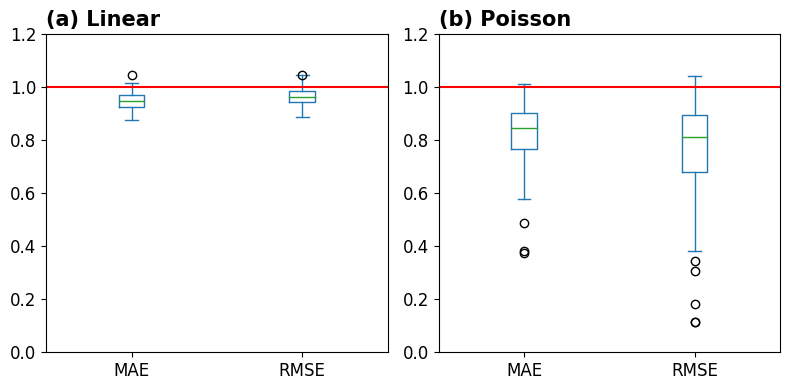

In [33]:
def special_div(x, y):
    """ 
    Special division operation
    """
    if y == 0:
        y = 1e-5
    return x/y

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(4)
fig.set_figwidth(8)
title_size = 15
text_size = 12

# plt.subplot(1,2,1)
score_path = os.path.join(output_dir, "exp5_linear_score_"+str(n_components)+".csv")

scores_df = pd.read_csv(score_path, index_col=None, header=0)

source_mae = scores_df['source_mae']
source_rmse = scores_df['source_rmse']

trans_source_mae = scores_df['trans_source_mae']
trans_source_rmse = scores_df['trans_source_rmse']

# transported source to source mae
trans_source_source_mae = [special_div(i, j) for i, j in zip(trans_source_mae, source_mae)]

# transported source to source rmse
trans_source_source_rmse = [special_div(i, j) for i, j in zip(trans_source_rmse, source_rmse)]


# Pandas dataframe
data = pd.DataFrame({
    'MAE': trans_source_source_mae,
    'RMSE': trans_source_source_rmse
})

# Plot the dataframe
ax = data[['MAE', 'RMSE']].plot(kind='box', ax=axes[0])

# Plot the baseline
ax.axhline(y = 1, color = 'r', linestyle = '-')

ax.tick_params(labelsize=text_size)
ax.set_ylim(0, 1.2)
ax.set_title("(a) Linear", fontweight='bold', loc='left', fontsize=title_size)

######################################################

score_path = os.path.join(output_dir, "exp5_poisson_score_"+str(n_components)+".csv")

scores_df = pd.read_csv(score_path, index_col=None, header=0)

source_mae = scores_df['source_mae']
source_rmse = scores_df['source_rmse']

trans_source_mae = scores_df['trans_source_mae']
trans_source_rmse = scores_df['trans_source_rmse']

# transported source to source mae
trans_source_source_mae = [special_div(i, j) for i, j in zip(trans_source_mae, source_mae)]

# transported source to source rmse
trans_source_source_rmse = [special_div(i, j) for i, j in zip(trans_source_rmse, source_rmse)]


# Pandas dataframe
data = pd.DataFrame({
    'MAE': trans_source_source_mae,
    'RMSE': trans_source_source_rmse
})

# Plot the dataframe
ax = data[['MAE', 'RMSE']].plot(kind='box', ax=axes[1])

# Plot the baseline
ax.axhline(y = 1, color = 'r', linestyle = '-')

ax.tick_params(labelsize=text_size)
ax.set_ylim(0, 1.2)
plt.title("(b) Poisson", fontweight='bold', loc='left', fontsize=title_size)
plt.tight_layout()

save_path = os.path.join(output_dir, "exp5_res_"+str(n_components)+".pdf")
plt.savefig(save_path, bbox_inches='tight')
plt.show()